# Preprocessing

In [1]:
# DATA WRANGLING
import numpy as np 
import pandas as pd
import re
from collections import Counter

# DATA VISUALISATION
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from matplotlib_venn_wordcloud import venn2_wordcloud
from highlight_text import HighlightText, ax_text, fig_text
import matplotx

# NLP
from bertopic import BERTopic
import spacy
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from textblob import TextBlob


# LOAD SPACY
def load_model(model):
    nlp = spacy.load(model)
    nlp.max_length=2000000

    return nlp 

load_model('en_core_web_trf')


In [2]:
df = pd.read_csv('raw data/menopause.csv')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def clean_df(df: pd.DataFrame):
    """
    Returns
    --------
    Cleansed pd.DataFrame

    Function drops any queries which are null and replaces null demos with Unknown. 
    Removes punctuation, extra spaces, replaces underscores and words over 14 characters.
    Removes stopwords from the corpus. 
    """
    df = df.dropna(subset=['query']).fillna('Unknown')
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['query'] = (df['query'].str.replace('_', ' ')
                                .str.replace('(\S{14,})|[^\w\s]|  +', '') # Remove words > 14 letters, puncutation, numbers, doublespaces
                                .str.strip()
                                .str.lower()
                                .apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords)])))
    return df

df = clean_df(df)


# Sentiment

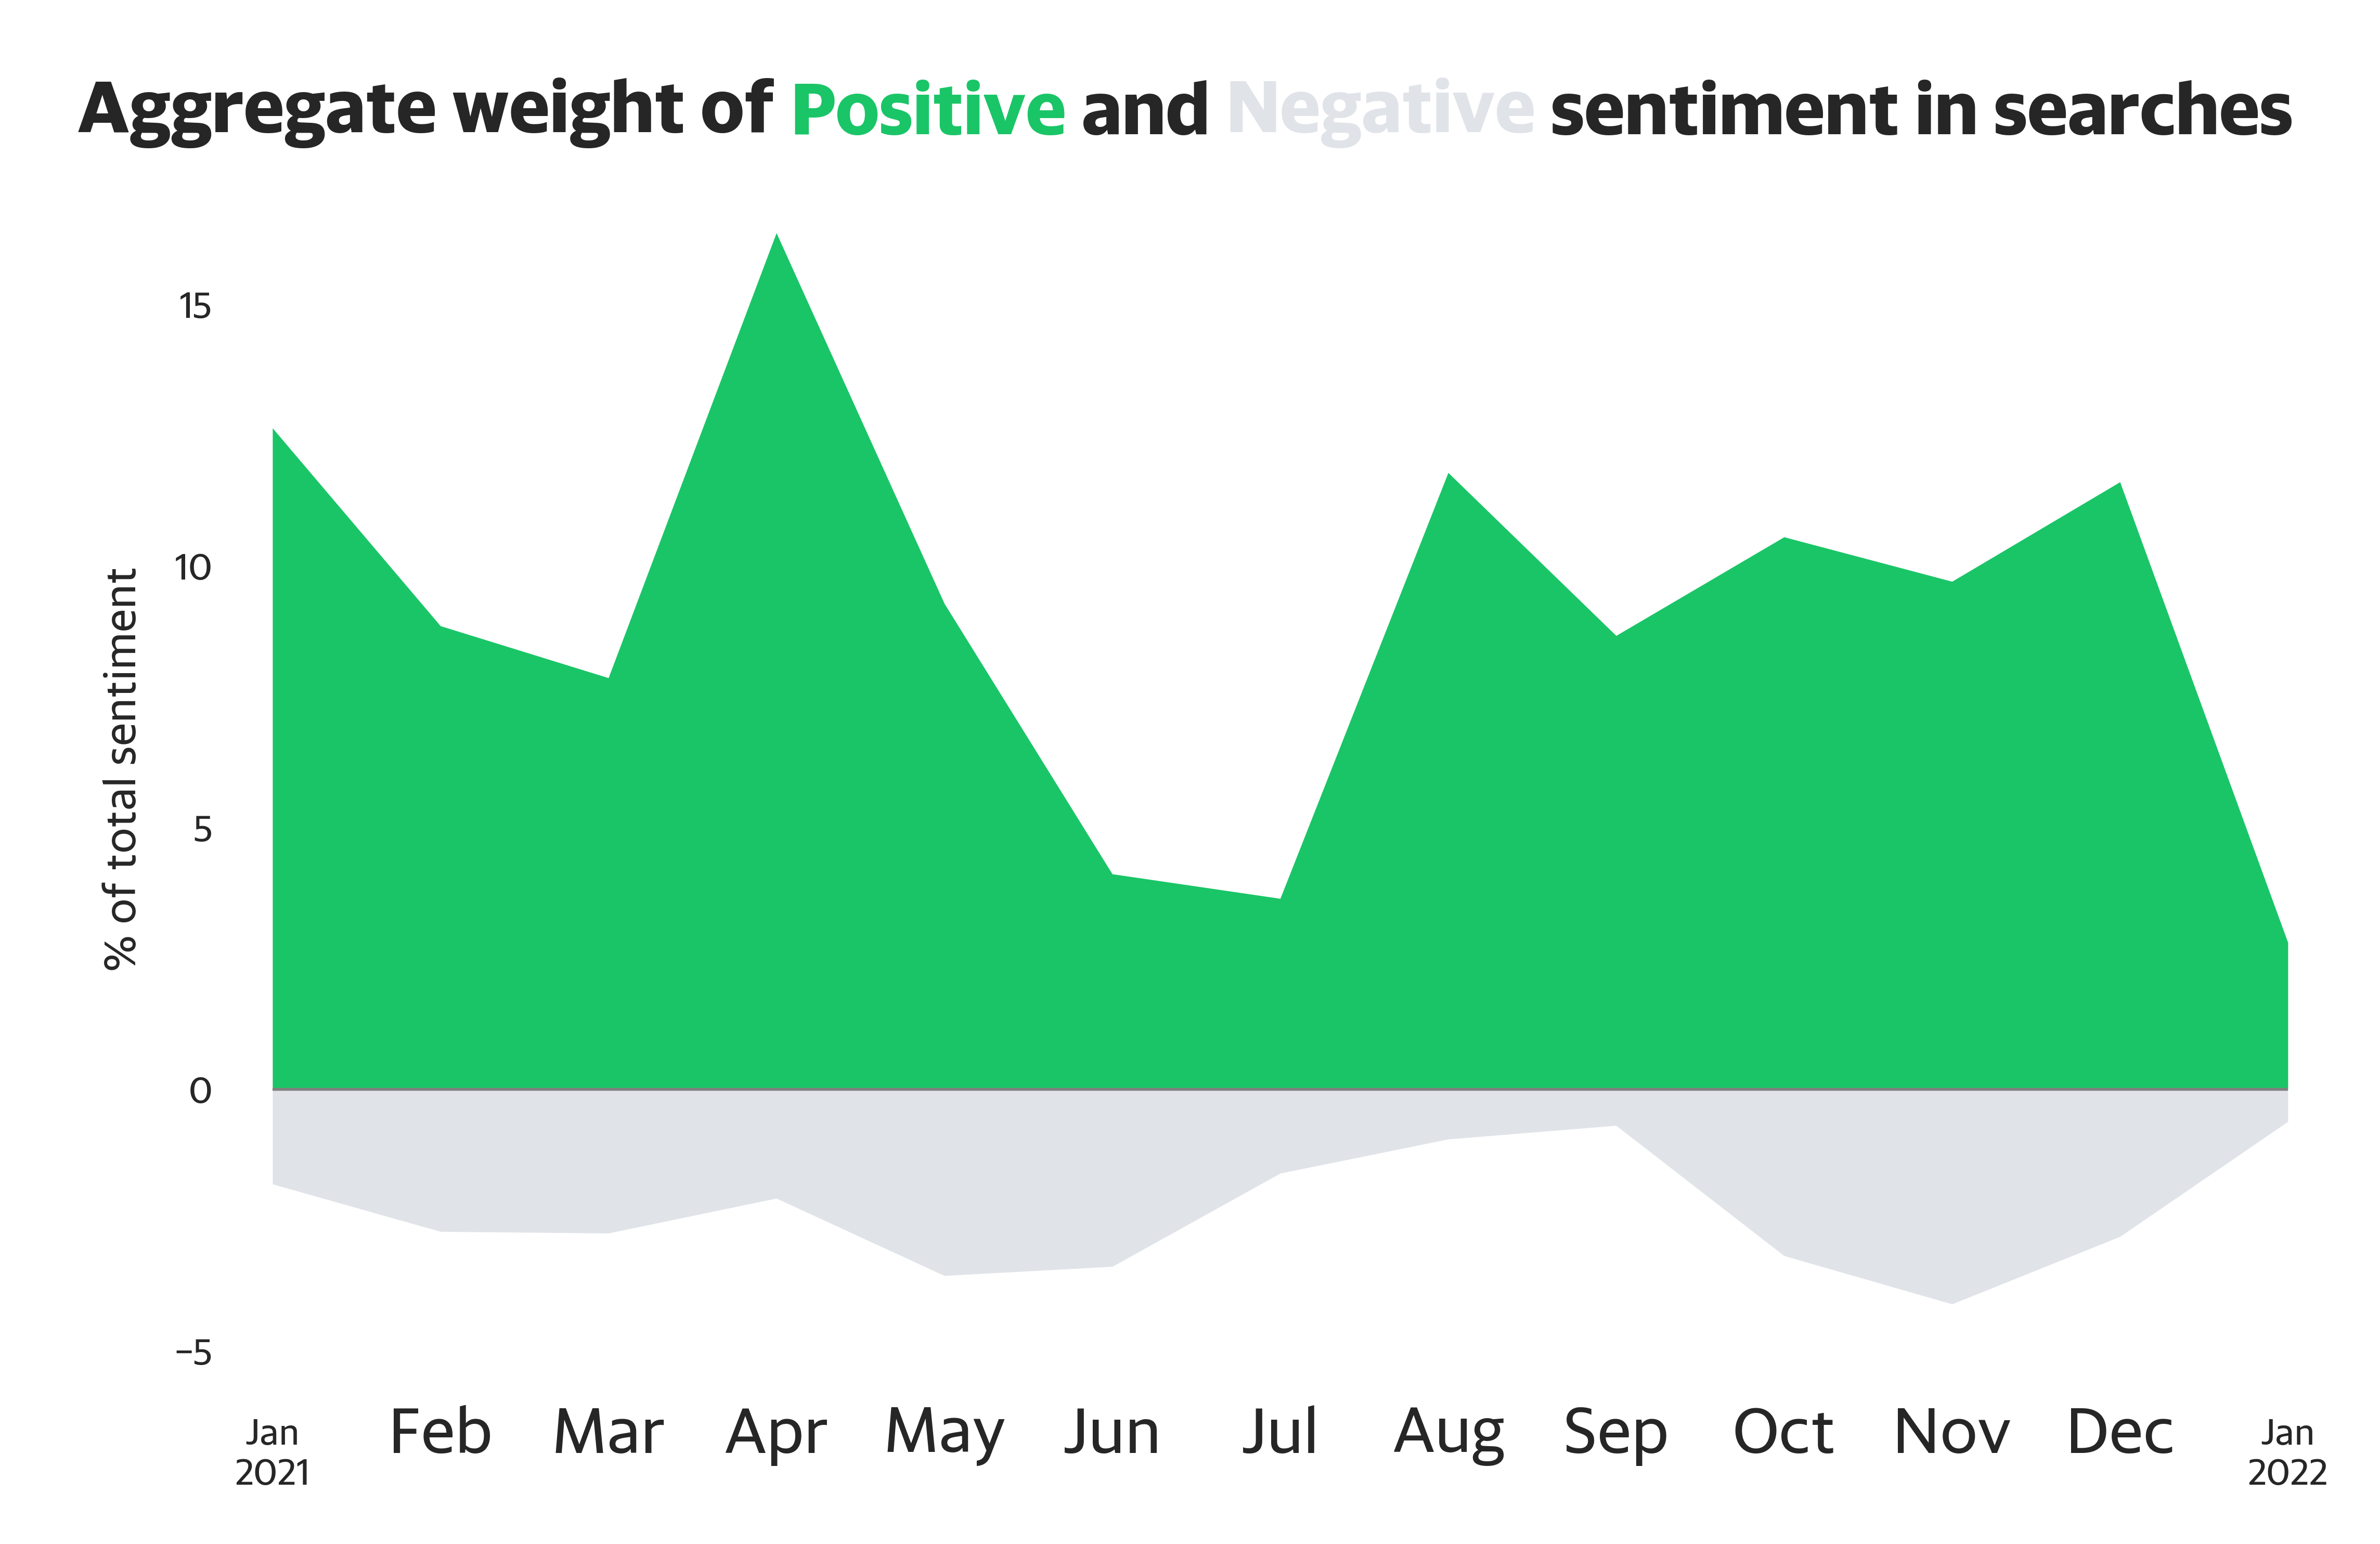

In [356]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

def sentiment_plot(df, offset='W-MON'):
    # Assign Sentiment
    df['score'] = df['query'].apply(sentiment_calc)
    df['sentiment'] = pd.cut(df['score'], bins=[-1, -0.2, 0.2, 1],labels=['Negative', 'Neutral', 'Positive'])

    # Shape Data
    df = (df
            .set_index('date')                      
            .sort_index()                           
            .groupby(['sentiment'])['score']           
            .resample(offset)                       
            .sum()                                  
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100)
            .pivot_table(index='date', columns='sentiment', values='pct', aggfunc='sum')
            .drop('Neutral', axis=1))

    # Typography and Colour 
    font = {'family' : 'Yahoo Sans', 'weight':'normal'}
    plt.rc('font', **font)
    sent_colors = {'very Negative':'#E0E4E9', 'Negative':'#E0E4E9', 'Neutral':'Grey', 'Positive':'#1AC567', 'very Positive':'#00873C'}

    # Grid & data
    fig, ax = plt.subplots(figsize=(5,3), dpi=1000)
    df.plot.area(color=sent_colors, legend=False, lw=0, ax=ax)

    # Axes
    ax.set(xlabel="")
    ax.set_ylabel('% of total sentiment', fontsize=6)
    ax.axhline(y=0, color='grey', zorder=10, lw=0.4)
    ax.tick_params('both', labelsize=5)

    # Title
    s = 'Aggregate weight of <Positive> and <Negative> sentiment in searches'
    fig_text(0.05, 0.9, s, fontweight='bold', fontsize=10, va='bottom', highlight_textprops=[{"color": "#1AC567", "fontweight":'bold'},
                                                                        {"color": "#E0E4E9", "fontweight":"bold"}])

    # Aesthetics
    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    sns.despine(left=True, bottom=True)



sentiment_plot(df, 'M')




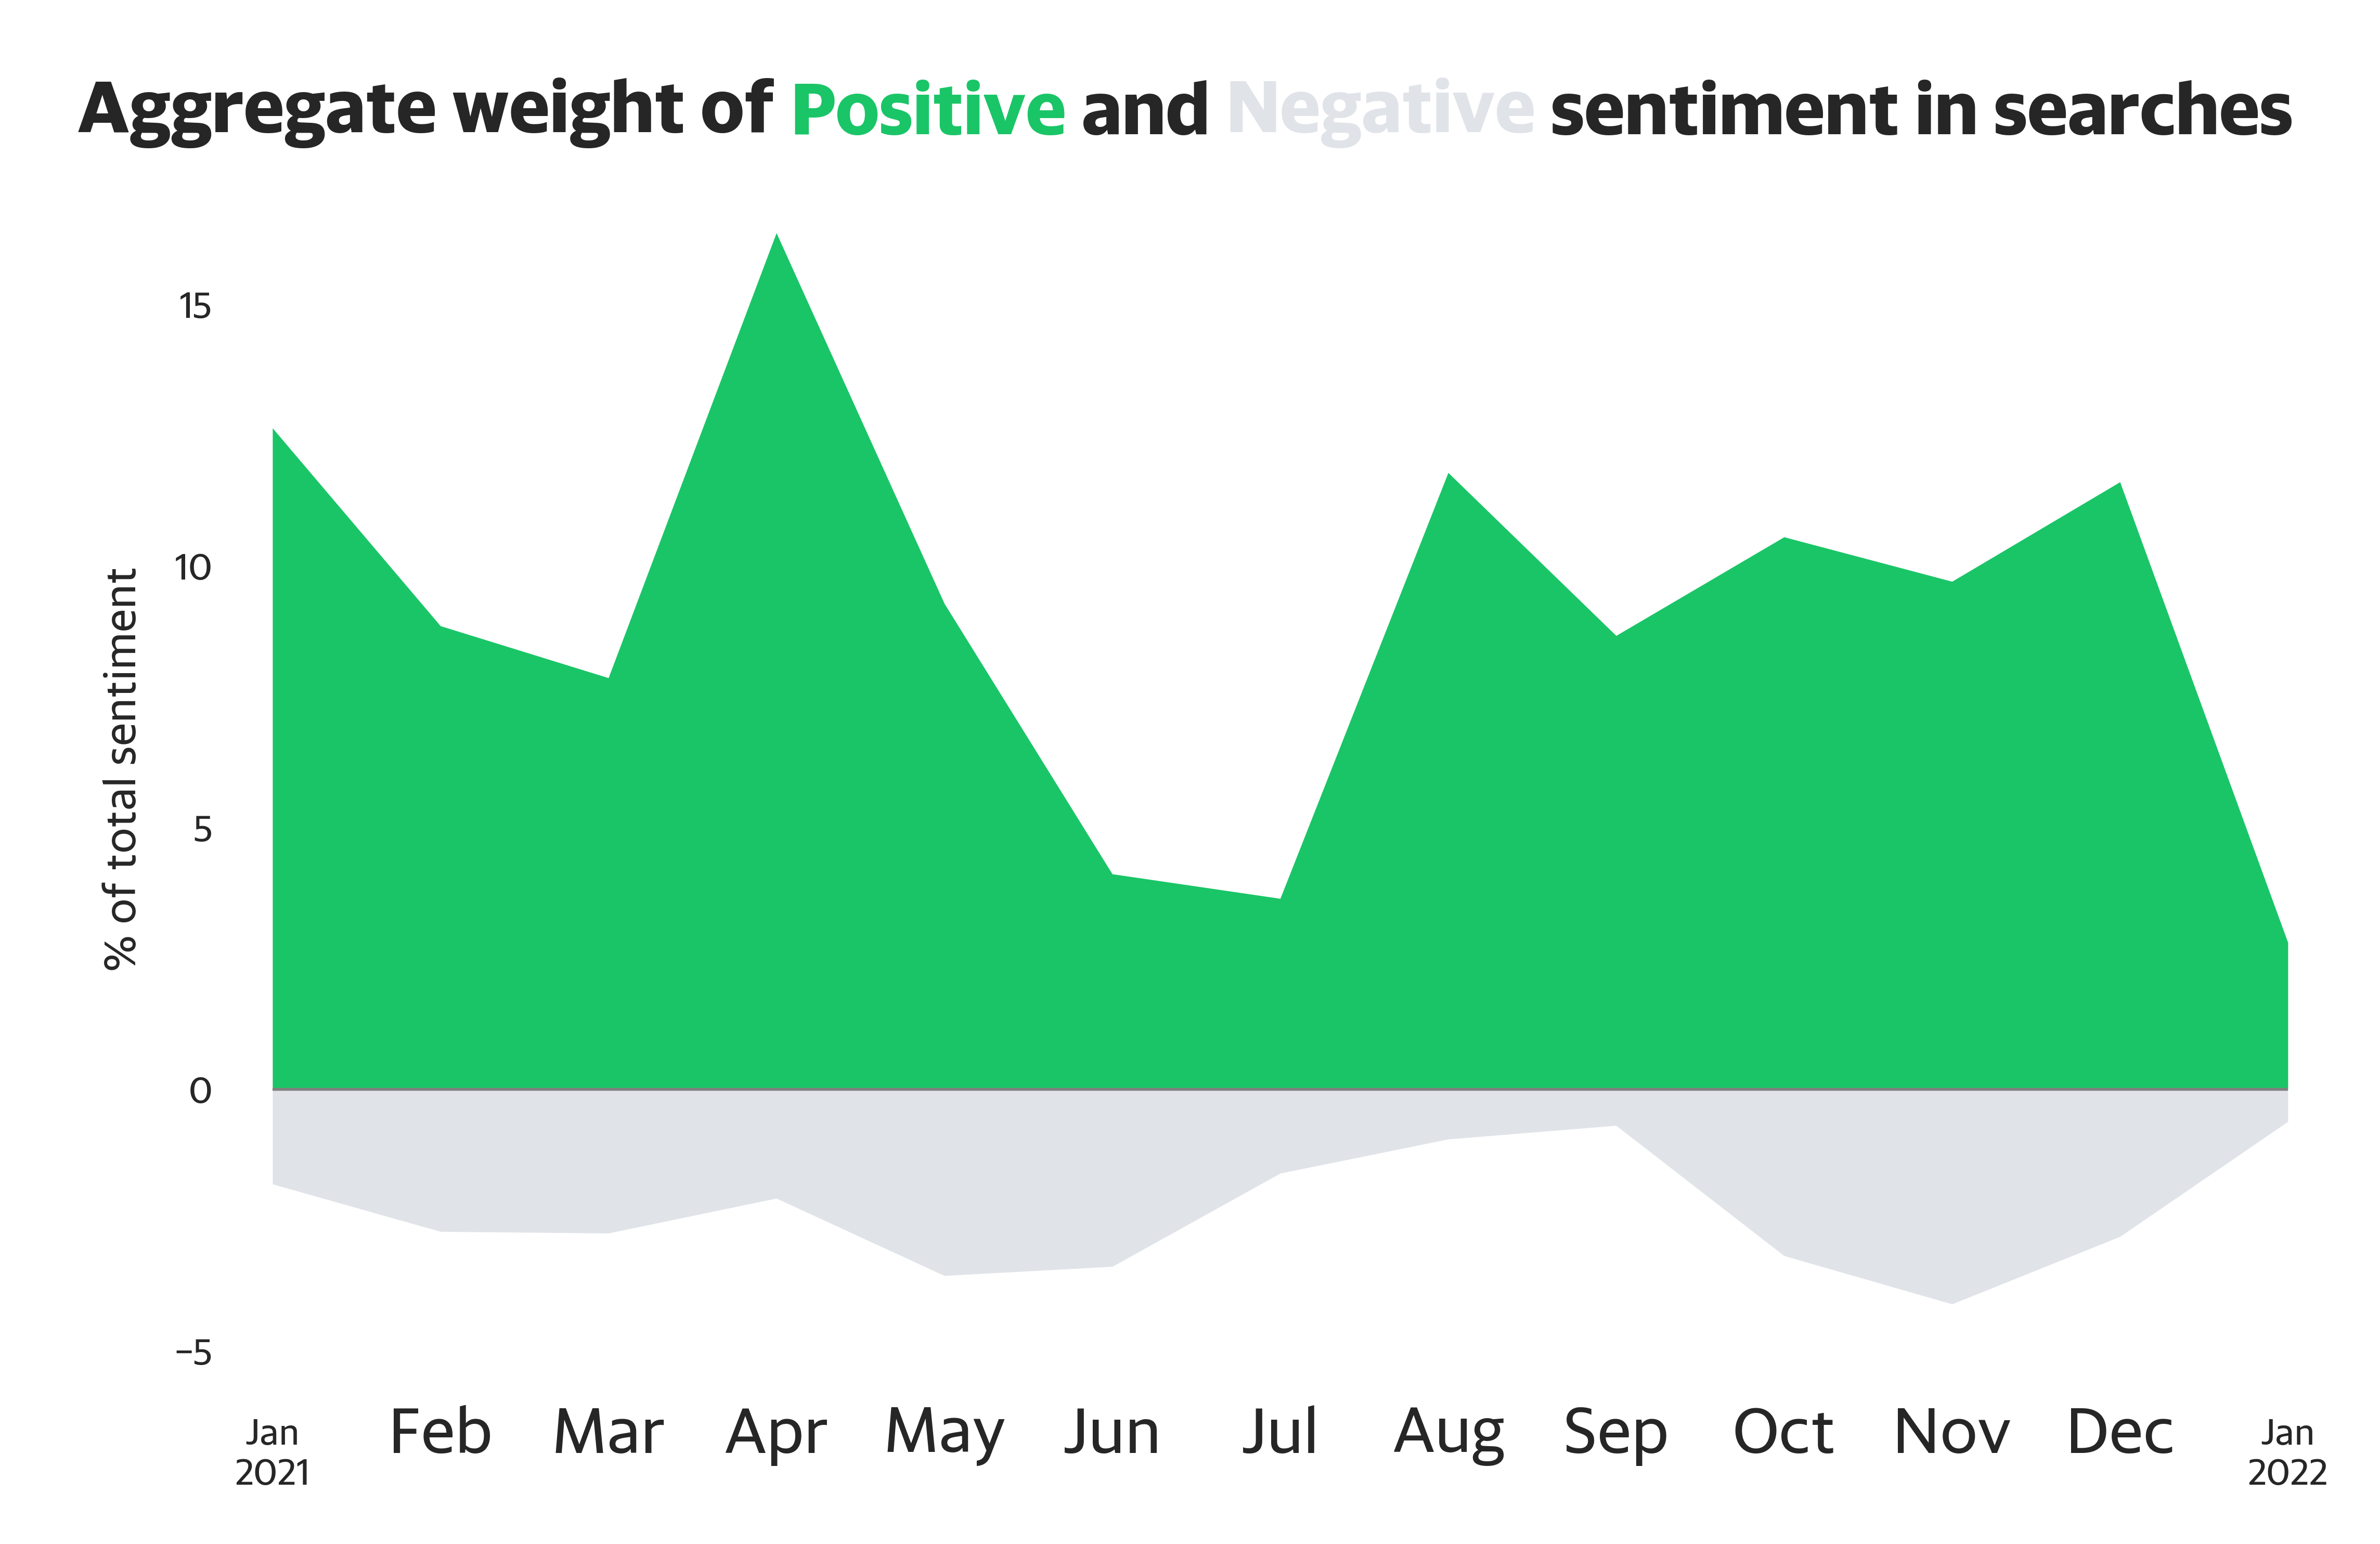

In [346]:
def sentiment_calc(text):
    try:
        return TextBlob(text).polarity
    except:
        return None

def assign_sentiment(df):
    """Simple sentiment - positive or negative"""
    df['score'] = df['query'].apply(sentiment_calc)
    df['sentiment'] = pd.cut(df['score'], bins=[-1, -0.2, 0.2, 1],labels=['Negative', 'Neutral', 'Positive'], )
    return df

def sentiment_plot(df, offset='W-MON'):
    """Creates a weekly summary of sentiment"""
    return (df
            .set_index('date')                      # set date as the index
            .sort_index()                           # make sure dates are sorted chronologically
            .groupby(['sentiment'])['score']        # group dates by sentiment, and display their scores    
            .resample(offset)                      # changes the aggregation to weekly from daily for a smoother chart
            .sum()                                  # sum that weeks worth of sentiment
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100)
            .pivot_table(index='date', columns='sentiment', values='pct', aggfunc='sum')
            .drop('Neutral', axis=1))


df = assign_sentiment(df)
week_sent = sentiment_plot(df, offset='M')


def sentiment_plot(df):
    # Typography and Colour 
    font = {'family' : 'Yahoo Sans', 'weight':'normal'}
    plt.rc('font', **font)
    sent_colors = {'very Negative':'#E0E4E9', 'Negative':'#E0E4E9', 'Neutral':'Grey', 'Positive':'#1AC567', 'very Positive':'#00873C'}

    # Grid & data
    fig, ax = plt.subplots(figsize=(5,3), dpi=1000)
    df.plot.area(color=sent_colors, legend=False, lw=0, ax=ax)

    # Axes
    ax.set(xlabel="")
    ax.set_ylabel('% of total sentiment', fontsize=6)
    ax.axhline(y=0, color='grey', zorder=10, lw=0.4)
    ax.tick_params('both', labelsize=5)

    # Title
    s = 'Aggregate weight of <Positive> and <Negative> sentiment in searches'
    fig_text(0.05, 0.9, s, fontweight='bold', fontsize=10, va='bottom', highlight_textprops=[{"color": "#1AC567", "fontweight":'bold'},
                                                                        {"color": "#E0E4E9", "fontweight":"bold"}])

    # Aesthetics
    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    sns.despine(left=True, bottom=True)

    # return fig

sentiment_plot(week_sent)


In [223]:
def weekly_sentiment(df):
    """Creates a weekly summary of sentiment"""
    return (df
            .query('sentiment != "Neutral"')
            .set_index('date')                      # set date as the index
            .sort_index()                           # make sure dates are sorted chronologically
            .groupby(['sentiment'])['score']        # group dates by sentiment, and display their scores    
            .resample('W-MON')                      # changes the aggregation to weekly from daily for a smoother chart
            .sum()                                  # sum that weeks worth of sentiment
            .reset_index()
            .assign(pct=lambda df_:df_['score'] / df_['score'].sum() * 100))

week_sent = weekly_sentiment(df)

# Entities

In [43]:
tokens = nlp(''.join(str(df['query'].tolist())))
entities = [(x.text, x.label_) for x in tokens.ents]


In [44]:
entities = pd.DataFrame(entities).rename(columns={0:"entity", 1:"label"})

In [5]:
(entities
    # .query('label == "ORG"')
    .groupby('entity').count()
    .reset_index()
    .nlargest(10, 'label')
)

NameError: name 'entities' is not defined

# Aspects

In [79]:
sentences = df['query'].to_list()

aspects = []
for sentence in sentences:
  doc = nlp(sentence)
  descriptive_term = ''
  target = ''
  for token in doc:
    if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
      target = token.text
    if token.pos_ == 'ADJ':
      prepend = ''
      for child in token.children:
        if child.pos_ != 'ADV':
          continue
        prepend += child.text + ' '
      descriptive_term = prepend + token.text
  aspects.append({'aspect': target,
    'description': descriptive_term})

In [129]:
from textblob import TextBlob
for aspect in aspects:
  aspect['sentiment'] = TextBlob(aspect['description']).polarity

df_aspect = pd.DataFrame(aspects)

(df_aspect
.groupby('aspect', as_index=False)
.agg(sentiment=('sentiment', 'mean'), count=('sentiment', 'size'))
.sort_values('count', ascending=False)
.head(50)
.style
.background_gradient(subset='sentiment')
)

,aspect,sentiment,count
0,,0.017937,3970
83,heat,0.146667,15
134,pumps,0.100000,9
173,ways,0.087500,8
16,brands,-0.128571,7
42,companies,0.000000,6
18,business,0.200000,6
13,boots,0.000000,5
114,oil,0.350000,4
133,pump,0.225000,4


In [133]:
df_aspect.query('aspect == "heat"')

,aspect,description,sentiment
1669,heat,,0.0
2131,heat,,0.0
2437,heat,,0.0
2481,heat,,0.0
2604,heat,good,0.7
2645,heat,,0.0
2879,heat,electric,0.0
2979,heat,,0.0
3050,heat,good,0.7
3058,heat,,0.0


In [120]:
(df_aspect
.groupby('aspect', as_index=False)
.sum()
.sort_values('sentiment', ascending=False)
)

,aspect,sentiment
0,,71.208628
83,heat,2.200000
114,oil,1.400000
18,business,1.200000
72,fish,1.000000
...,...,...
156,students,-0.300000
43,conditions,-0.300000
154,steps,-0.400000
8,avocado,-0.700000


In [74]:
aspects = pd.DataFrame(aspects)
aspects.dropna(subset=['aspect'])
aspects.query('aspect != ""')[['aspect', 'description']].value_counts().head(50)

aspect         description             
heat                                       9
pumps                                      7
boots                                      5
business       economically sustainable    4
ways           sustainable                 4
heat           good                        4
companies      sustainable                 4
brands                                     3
clients        overall                     3
choice         identifiable                3
covid          sustainable                 3
item           sustainable                 2
cafes          sustainable                 2
tourists       unsustainable               2
metric                                     2
consumers                                  2
systems        central                     2
item           sustanible                  2
challenges     sustainable                 2
funds          double                      2
steps          green                       2
ships          

# Wordcloud

In [ ]:
# Colour format 
def purple(word=None, font_size=None,
                       position=None, orientation=None,
                       font_path=None, random_state=None):
    h = 267 # 0 - 360
    s = 99 # 0 - 100
    l = random_state.randint(50, 80) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)
    
def create_wordcloud(df):
    # Aesthetics
    font = {'family' : 'Yahoo Sans', 'weight' : 'bold'}
    plt.rc('font', **font)

    # Create spaCy document and tokenise 
    doc = nlp(" ".join(df_words.query('age in @age_selection and gender in @gender_selection')[searches].to_list()))
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.pos_ in parts_option]
    tokens = Counter(tokens)

    # Instantiate wordcloud object
    wc = WordCloud(background_color='white', 
               color_func=purple,
               collocations=True,
               max_words=200,
               width=1200, height=1000, prefer_horizontal=0.9)

    wc = wc.generate_from_frequencies(tokens)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    st.pyplot(fig)




# Create copy of dataframe for use in wordcloud
df_words = df.copy()

# Demographic Selection
ages = df[age].unique().tolist()
genders = df[gender].unique().tolist()
parts = ['ADJ', 'NOUN', 'VERB', 'PRON']

# User Selectable Configuration
with st.form(key='wordkey'):
    age_selection = st.multiselect('Select Age', ages, default=ages)
    gender_selection = st.multiselect('Select Gender', genders, default=genders)
    parts_option = st.multiselect(label='Select Part of Speech', options= parts, default=['NOUN'])
    st.form_submit_button('Submit Choices') 






clean_words = {key:value for key, value in Counter(tokens).items()}





# Autocorrelation

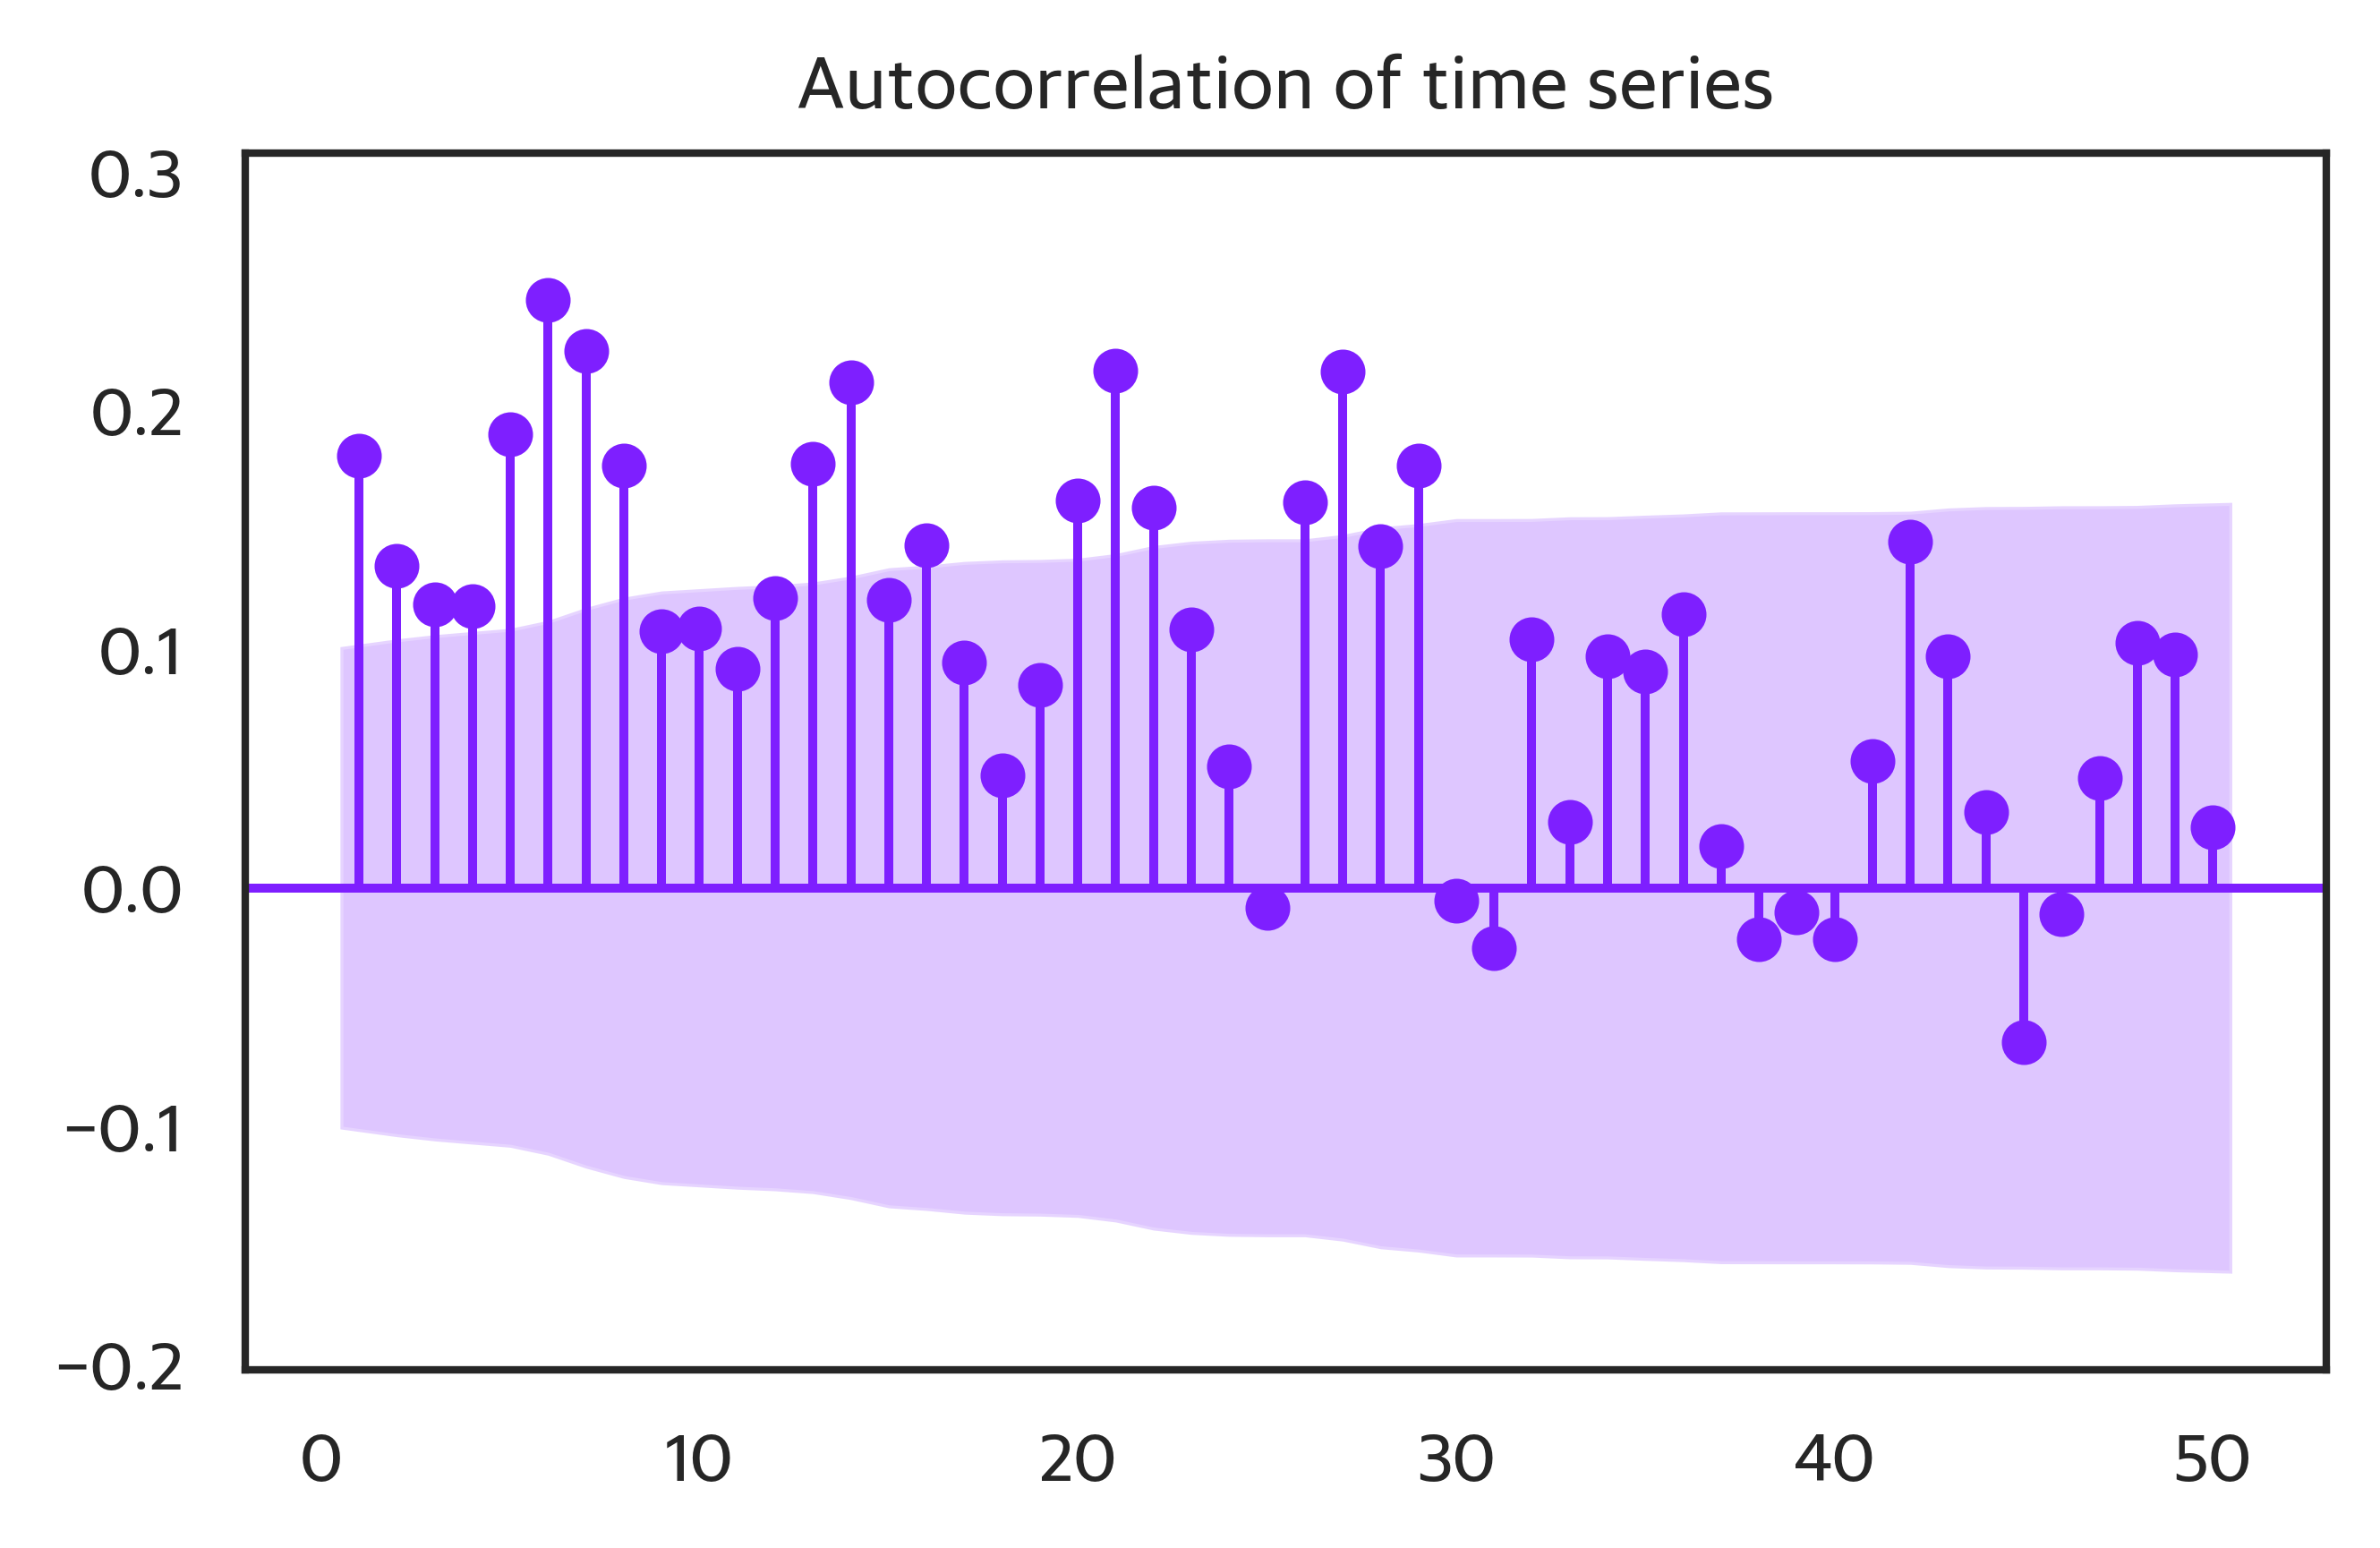

In [386]:
from statsmodels.graphics.tsaplots import plot_acf


fig, ax = plt.subplots(figsize=(5,3), dpi=600)
daily_queries = df.groupby('date').size()
plot_acf(x=daily_queries, lags=50, ax=ax, use_vlines=True, missing='conservative', zero=False, auto_ylims=True, title='Autocorrelation of time series')

plt.show()

# Prophet

In [620]:
date = 'date'
from prophet import Prophet

def research_dates(df):
    return (df[date].dt.date.min().strftime('%-d %b %Y'), df[date].dt.date.max().strftime('%-d %b %Y'))

def country_codes():
    codes = (pd.read_csv('raw data/country_codes.csv')
                   .assign(Code=lambda df: df['ISO code'].str.split('/').str[0])
                   .drop('ISO code', axis='columns'))
        
    return codes

def is_spring_summer(ds):
    dt = pd.to_datetime(ds)
    return dt.quarter == 2 | dt.quarter == 3

holidays = pd.read_csv('raw data/custom_holidays.csv')
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d/%m/%Y')


df_prophet = (df
                .groupby(date, as_index=False).size()
                .rename({date:'ds', 'size':'y'}, axis='columns')
                .sort_values('ds')
                .assign(autumn_winter=lambda df:~df['ds'].apply(is_spring_summer),
                        spring_summer=lambda df:df['ds'].apply(is_spring_summer)))

# Instantiate
m = Prophet(holidays=holidays, weekly_seasonality=False)

# Configure & Fit 
m.add_country_holidays(country_name='UK') 
m.add_seasonality(name='weekly_springsummer', period=7, fourier_order=3, condition_name='spring_summer')
m.add_seasonality(name='weekly_autumnwinter', period=7, fourier_order=3, condition_name='autumn_winter')
m.fit(df_prophet)

# Predict
future = m.make_future_dataframe(periods=30)
future['autumn_winter'] = ~future['ds'].apply(is_spring_summer)
future['spring_summer'] = future['ds'].apply(is_spring_summer)

forecast = m.predict(future)
cols = ['ds', 'holidays', 'weekly_springsummer', 'weekly_autumnwinter', 'yhat']
df_seasonality = (pd.concat([forecast[cols], df_prophet['y']], axis='columns')
                    .dropna()
                    .assign(holiday_impact=lambda df: df['holidays'] / df['y'],
                                      ss_weeklyimpact=lambda df: df['weekly_springsummer'] / df['y'],
                                      aw_weeklyimpact=lambda df: df['weekly_autumnwinter'] / df['y'],
                                      dayofweek=lambda df: df['ds'].dt.day_name(),
                                      weekday=lambda df: df['ds'].dt.dayofweek))


def holiday_cleanup(ser):
    return (ser.str.replace('[England/Wales/Northern Ireland]', '', regex=False)
               .str.replace(' [Northern Ireland]', '', regex=False)
    )


df_holidays = (m.construct_holiday_dataframe(df_seasonality['ds'])
                .assign(holiday=lambda df: holiday_cleanup(df['holiday']))
                .set_index('ds'))

# holiday_impact = pd.concat([df_seasonality.set_index('ds'), df_holidays], axis='columns', join='inner').reset_index()

cols = ['ds', 'holidays', 'holiday_impact', 'yhat', 'y']

holiday_impact = (pd.concat([df_seasonality[cols].set_index('ds'), df_holidays], axis='columns')
                    .reset_index()
                    .query('holidays != 0')
                    .dropna(subset=['holidays'])
                    .fillna(''))

scot = holiday_impact['holiday'].str.contains("Scotland")
holiday_impact = holiday_impact.loc[~scot]

research_start, research_end = research_dates(df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.2817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       532.735   0.000433876        76.277      0.8037      0.8037      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       533.362   1.40014e-05        92.512      0.8099      0.8099      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       533.366   4.04706e-05       77.0564   4.451e-07       0.001      307  LS failed, Hessian reset 
     245       533.368   3.16415e-09       80.8743      0.1449      0.1449      365   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [307]:
research_start = df[date].dt.date.min().strftime('%-d %b %Y')
research_end = df[date].dt.date.max().strftime('%-d %b %Y')


'2 Jan 2021'

In [584]:
def holiday_cleanup(ser):
    return (ser.str.replace('[England/Wales/Northern Ireland]', '', regex=False)
               .str.replace(' [Northern Ireland]', '', regex=False)
    )

def hol_impact(df):
    df_holidays = (pd.read_csv('raw data/custom_holidays.csv')
                        .assign(ds=lambda df: pd.to_datetime(df['ds']))
                        .filter(['ds', 'holiday'], axis='columns')
                        .append(m.construct_holiday_dataframe(df_seasonality['ds']))
                        .assign(holiday=lambda df: holiday_cleanup(df['holiday']))
                        .set_index('ds'))

    holiday_impact = pd.concat([df_seasonality.set_index('ds'), df_holidays], axis='columns', join='inner').reset_index()

    cols = ['ds', 'holidays', 'holiday_impact', 'yhat', 'y']

    holiday_impact = (pd.concat([df_seasonality[cols].set_index('ds'), df_holidays], axis='columns')
                    .reset_index()
                    .query('holidays != 0')
                    .dropna(subset=['holidays'])
                    .fillna(''))

    scot = holiday_impact['holiday'].str.contains("Scotland")
    holiday_impact = holiday_impact.loc[~scot]

    return holiday_impact



In [ ]:

def holiday_impact_plot(df):
    fig, ax = plt.subplots(figsize=(6,3), dpi=1000)

    sns.set(font='Yahoo Sans', style='white')
    df['holiday_impact'] = df['holiday_impact'] * 100
    df.plot(x='holiday', y='holiday_impact', color=df['holiday_impact'].ge(0).map({True: '#7E1FFF', False:'lightgrey'}), kind='barh', width=1, ax=ax)

    # Labels
    ax.set_ylabel('')
    ax.set_xlabel('% lift in searches', fontsize=6, fontweight='bold')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelsize=5, pad=0)

    # Spines
    sns.despine(left=True, bottom=False)

    for direction in ['bottom', 'left']:
        ax.spines[direction].set_lw(0.2)
        ax.spines[direction].set_color('grey')
        ax.spines[direction].set_alpha(0.5)
    
    ax.grid(which='major', axis='x', dashes=(1,3), zorder=4, color='gray', ls=':', alpha=0.5, lw=0.2)
    ax.grid(axis='y', visible=False)
    # ax.axvline(0, lw=0.2, color='black')
    # Title
    s = '% Lift in Searches by Holiday & Event'
    s2 = 'The chart shows the <Positive> and <Negative> impact on searches during holidays' 
    fig_text(0.00, 0.92, s, fontweight='bold', fontsize=12, va='bottom',  color='#6001D2')

    fig_text(0.00, 0.89, s2, fontsize=6, va='bottom', highlight_textprops=[{"color": "#7E1FFF", "fontweight":'bold'},
                                                                            {"color": "lightgrey", "fontweight":"bold"}])

    # Adjust axes positions to fit commentary
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0, pos1.y0 - 0.05,  pos1.width, pos1.height]
    ax.set_position(pos2)

    # Source
    fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=4, x=0.9, y=-0.05, ha='right')
    ax.get_legend().remove()
    plt.savefig('holiday_impact.png', dpi=1000, transparent=True)


holiday_impact_plot(holiday_impact)

In [192]:
def weekly_impact_plot(df):
        days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        weekly_impact = (df_seasonality
                    .groupby('dayofweek')
                    .agg(ss=('weekly_springsummer', 'sum'),
                         aw=('weekly_autumnwinter', 'sum'),
                         pred=('yhat', 'sum'))
                    .reindex(days)
                    .assign(ss_impact=lambda df: df['ss'] / df['pred'] * 100,
                            aw_impact=lambda df: df['aw'] / df['pred'] * 100)
                    .reset_index())
                    
        seasonal_impact = (weekly_impact.melt(id_vars='dayofweek', var_name='season', value_vars=['ss_impact', 'aw_impact'], value_name='impact'))  

        sns.set(font='Yahoo Sans', style='white')
        fig, ax = plt.subplots(figsize=(6,3), dpi=1000)
        sns.barplot(x='dayofweek', y='impact', hue='season', palette=['#7E1FFF', 'lightgrey'], lw=0, ec='black', data=seasonal_impact, ax=ax);

        # Labels
        ax.xaxis.set_ticks_position('top')
        ax.set_xlabel('')
        ax.set_ylabel('% lift in searches', fontsize=6, fontweight='bold')
        ax.tick_params(axis='y', which='both', bottom=False, top=False, left=False, labelsize=5, labeltop=True, pad=-10)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, left=False, labelsize=5, labeltop=True, pad=0)
        yticks = ax.get_yticks()

        # Spines
        sns.despine(left=True, bottom=True)

        for direction in ['bottom', 'left']:
                ax.spines[direction].set_lw(0.2)
                ax.spines[direction].set_color('grey')
                ax.spines[direction].set_alpha(0.5)

        ax.grid(which='major', axis='y', dashes=(1,3), zorder=4, color='gray', ls=':', alpha=0.5, lw=0.2)
        ax.grid(axis='x', visible=False)

        # Title
        s = '% Lift in Searches by Day of Week'
        s2 = 'The chart shows weekday impact during the <Spring/Summer> and <Autumn/Winter> after accounting for public holidays' 
        fig_text(0.05, 0.92, s, fontweight='bold', fontsize=12, va='bottom',  color='#6001D2')

        fig_text(0.05, 0.89, s2, fontsize=6, va='bottom', highlight_textprops=[{"color": "#7E1FFF", "fontweight":'bold'},
                                                                                {"color": "lightgrey", "fontweight":"bold"}])

        
        # Caption
        fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=4, x=0.9, ha='right')

        # Custom Grouping Aesthetics
        for day in range(7):
                ax.plot([day - 0.45, day + 0.45], [yticks[-1], yticks[-1]], color='black', lw=0.5)

        ax.get_legend().remove()

        # Adjust axes positions to fit commentary
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 - 0.05,  pos1.width, pos1.height]
        ax.set_position(pos2)

        plt.savefig('weekly_impact.png', dpi=1000, transparent=True)



weekly_impact_plot(df_seasonality)

NameError: name 'df_seasonality' is not defined

In [659]:
codes = (pd.read_csv('raw data/country_codes.csv')
                   .assign(Code=lambda df: df['ISO code'].str.split('/').str[0])
                   .drop('ISO code', axis='columns'))

COUNTRY_CHOICES = codes.set_index('Code').to_dict()

list(COUNTRY_CHOICES.keys())

['Country']

In [668]:
COUNTRY_CHOICES = {'AO': 'Angola', 'AR': 'Argentina', 'AW': 'Aruba', 'AU': 'Australia', 'AT': 'Austria', 'AZ': 'Azerbaijan', 'BD': 'Bangladesh', 'BY': 'Belarus', 'BE': 'Belgium', 'BW': 'Botswana', 'BR': 'Brazil', 'BG': 'Bulgaria', 'BI': 'Burundi', 'CA': 'Canada', 'CL': 'Chile', 'CN': 'China', 'CO': 'Colombia', 'HR': 'Croatia', 'CW': 'Curacao', 'CZ': 'Czechia', 'DK': 'Denmark', 'DJ': 'Djibouti', 'DO': 'DominicanRepublic', 'EG': 'Egypt', 'EE': 'Estonia', 'ET': 'Ethiopia', 'ECB': 'EuropeanCentralBank', 'FI': 'Finland', 'FR': 'France', 'GE': 'Georgia', 'DE': 'Germany', 'GR': 'Greece', 'HN': 'Honduras', 'HK': 'HongKong', 'HU': 'Hungary', 'IS': 'Iceland', 'IN': 'India', 'IE': 'Ireland', 'IL': 'Israel', 'IT': 'Italy', 'JM': 'Jamaica', 'JP': 'Japan', 'KZ': 'Kazakhstan', 'KE': 'Kenya', 'KR': 'Korea', 'LV': 'Latvia', 'LS': 'Lesotho', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'MY': 'Malaysia', 'MW': 'Malawi', 'MX': 'Mexico', 'MA': 'Morocco', 'MZ': 'Mozambique', 'NL': 'Netherlands', 'NA': 'Namibia', 'NZ': 'NewZealand', 'NI': 'Nicaragua', 'NG': 'Nigeria', 'MK': 'NorthMacedonia', 'NO': 'Norway', 'PY': 'Paraguay', 'PE': 'Peru', 'PL': 'Poland', 'PT': 'Portugal', 'PTE': 'PortugalExt', 'RO': 'Romania', 'RU': 'Russia', 'SA': 'SaudiArabia', 'RS': 'Serbia', 'SG': 'Singapore', 'SK': 'Slovakia', 'SI': 'Slovenia', 'ZA': 'SouthAfrica', 'ES': 'Spain', 'SZ': 'Swaziland', 'SE': 'Sweden', 'CH': 'Switzerland', 'TW': 'Taiwan', 'TR': 'Turkey', 'TN': 'Tunisia', 'UA': 'Ukraine', 'AE': 'UnitedArabEmirates', 'UK': 'UnitedKingdom', 'US': 'UnitedStates', 'VE': 'Venezuela', 'VN': 'Vietnam', 'ZM': 'Zambia', 'ZW': 'Zimbabwe'}



In [682]:
from datetime import datetime
holidays = pd.read_csv('raw data/custom_holidays.csv')
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d/%m/%Y')

custom_holiday='Superbowl'
custom_date=datetime(2021,10,10)

holidays.append({'ds':custom_date, 'holiday':custom_holiday, 'lower_window':0, 'upper_window':0},  ignore_index=True)

,holiday,ds,lower_window,upper_window
0,New Years Eve,2021-12-31,0,0
1,Black Friday 2021,2021-11-26,0,0
2,Cyber Monday 2021,2021-11-29,0,0
3,Superbowl,2021-10-10,0,0


# Venn Wordcloud

# Timeseries

<AxesSubplot:xlabel='age', ylabel='perc'>

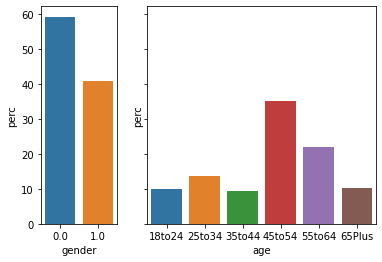

In [63]:
yahoo_palette_strict = "#39007D #7E1FFF #907CFF #003ABC #0F69FF #7DCBFF".split()

age_barplot = (df.query('age not in ["Unknown", "Below13"]')
                    .groupby('age', as_index=False)
                    .agg(total=('query', 'size'))
                    .assign(perc=lambda df: (df['total'] / df['total'].sum() * 100).round(1))
                    )

gender_barplot = (df.query('gender not in ["Unknown", "-1", -1]')
                    .groupby('gender', as_index=False)
                    .agg(total=('query', 'size'))
                    .assign(perc=lambda df: (df['total'] / df['total'].sum() * 100).round(1))
                    )
                    
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
sns.barplot(x = 'gender', y = 'perc',data=gender_barplot, ax=ax[0])
sns.barplot(x = 'age', y = 'perc',data=age_barplot, ax=ax[1])
# fig.text(x=0, y=1, s='hello there!!!', fontsize=20)
# fig.text(x=0, y=0.9, s='well look what we have here', fontsize=13)
# plt.subplots_adjust(top=0.85, left=0.1)


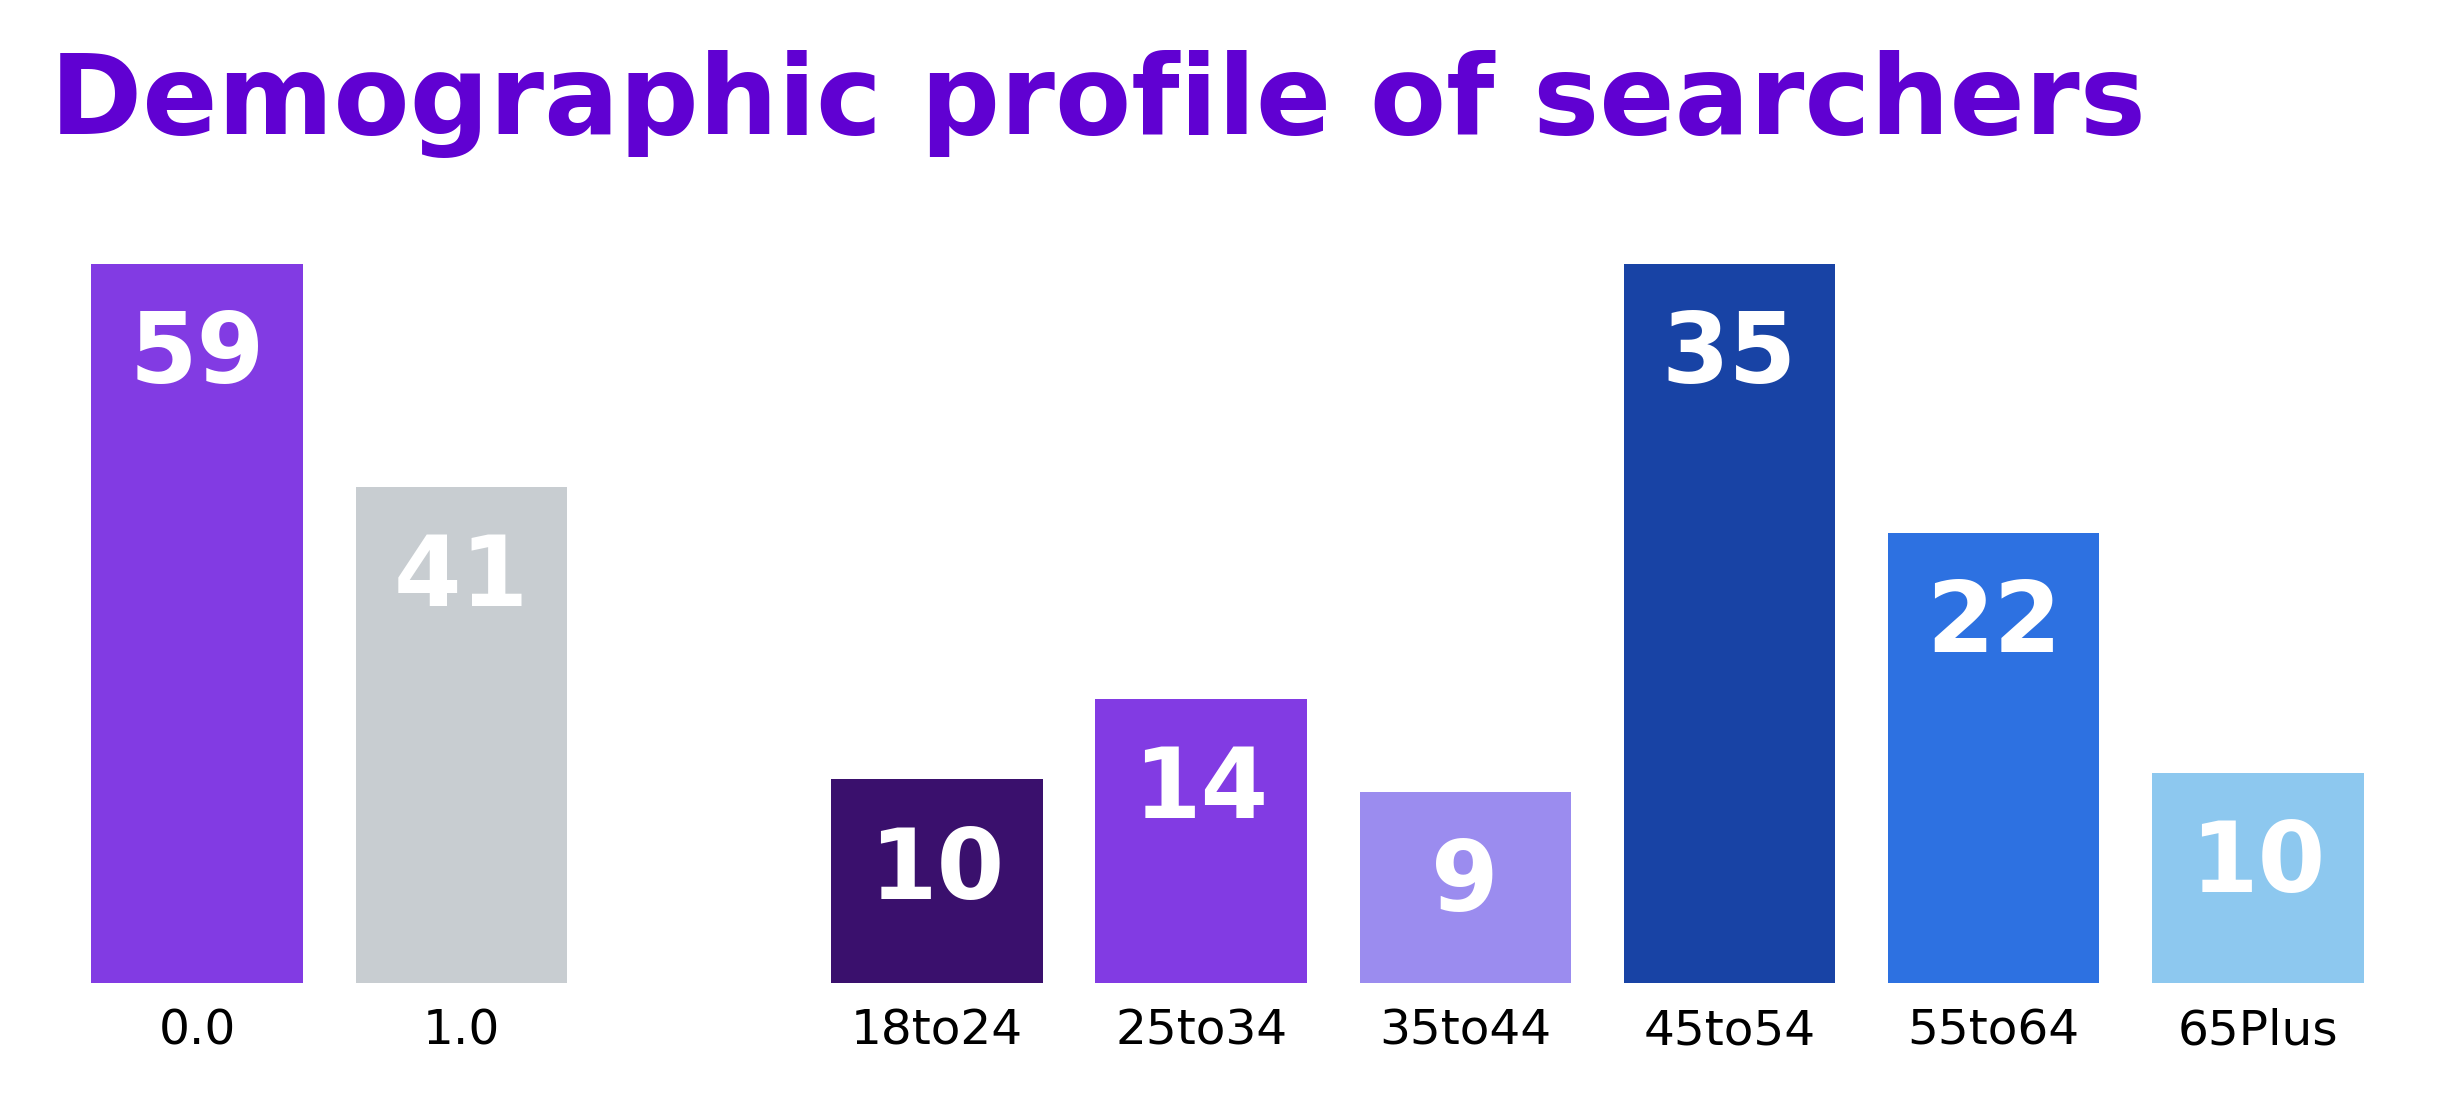

In [65]:
def demo_barplot(df):

    yahoo_palette_strict = "#39007D #7E1FFF #907CFF #003ABC #0F69FF #7DCBFF".split()

    age_barplot = (df.query('age not in ["Unknown", "Below13"]')
                    .groupby('age', as_index=False)
                    .agg(total=('query', 'size'))
                    .assign(perc=lambda df: (df['total'] / df['total'].sum() * 100).round(1))
                    )

    gender_barplot = (df.query('gender not in ["Unknown", "-1", -1]')
                    .groupby('gender', as_index=False)
                    .agg(total=('query', 'size'))
                    .assign(perc=lambda df: (df['total'] / df['total'].sum() * 100).round(1))
                    )
                    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,2),dpi=500, gridspec_kw={'width_ratios': [1, 3]})    
 
    sns.barplot(x = 'gender', y = 'perc',data=gender_barplot, palette=['#7E1FFF', '#C7CDD2'], ax=ax[0])
    sns.barplot(x = 'age', y = 'perc',data=age_barplot, palette=yahoo_palette_strict, ax=ax[1])

    # Axes
    for plot in [0, 1]:
        ax[plot].set_ylabel('')
        ax[plot].set_xlabel('')
        ax[plot].set_yticklabels('')
        # ax[plot].set_xticklabels(ax[plot].get_xticks(), rotation=0, weight='bold', size=7)
        ax[plot].bar_label(ax[plot].containers[0], size=14, color='white', weight='bold', label_type='edge', padding=-20, fmt='%.0f')
        ax[plot].tick_params(axis='both', which='both', bottom=False, top=False, right=False, left=False, labelsize=7, pad=0),

    sns.despine(bottom=True, left=True)

    xlabels = ax[1].get_xticklabels()

    # Title
    fig.text(x=0.12, y=0.95, s='Demographic profile of searchers', fontweight='extra bold', fontsize=16, va='bottom',  color='#6001D2')

    # Sourcing
    fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=4, x=0.9,y=-0.2, ha='right')
    plt.savefig('images/demo_barplot.svg', transparent=True, format='svg', dpi=1000, bbox_inches='tight')

    # plt.show()

    # return fig

# plt.savefig('images/demo_barplot.png', transparent=True, dpi=1000, bbox_inches='tight')

demo_barplot(df)



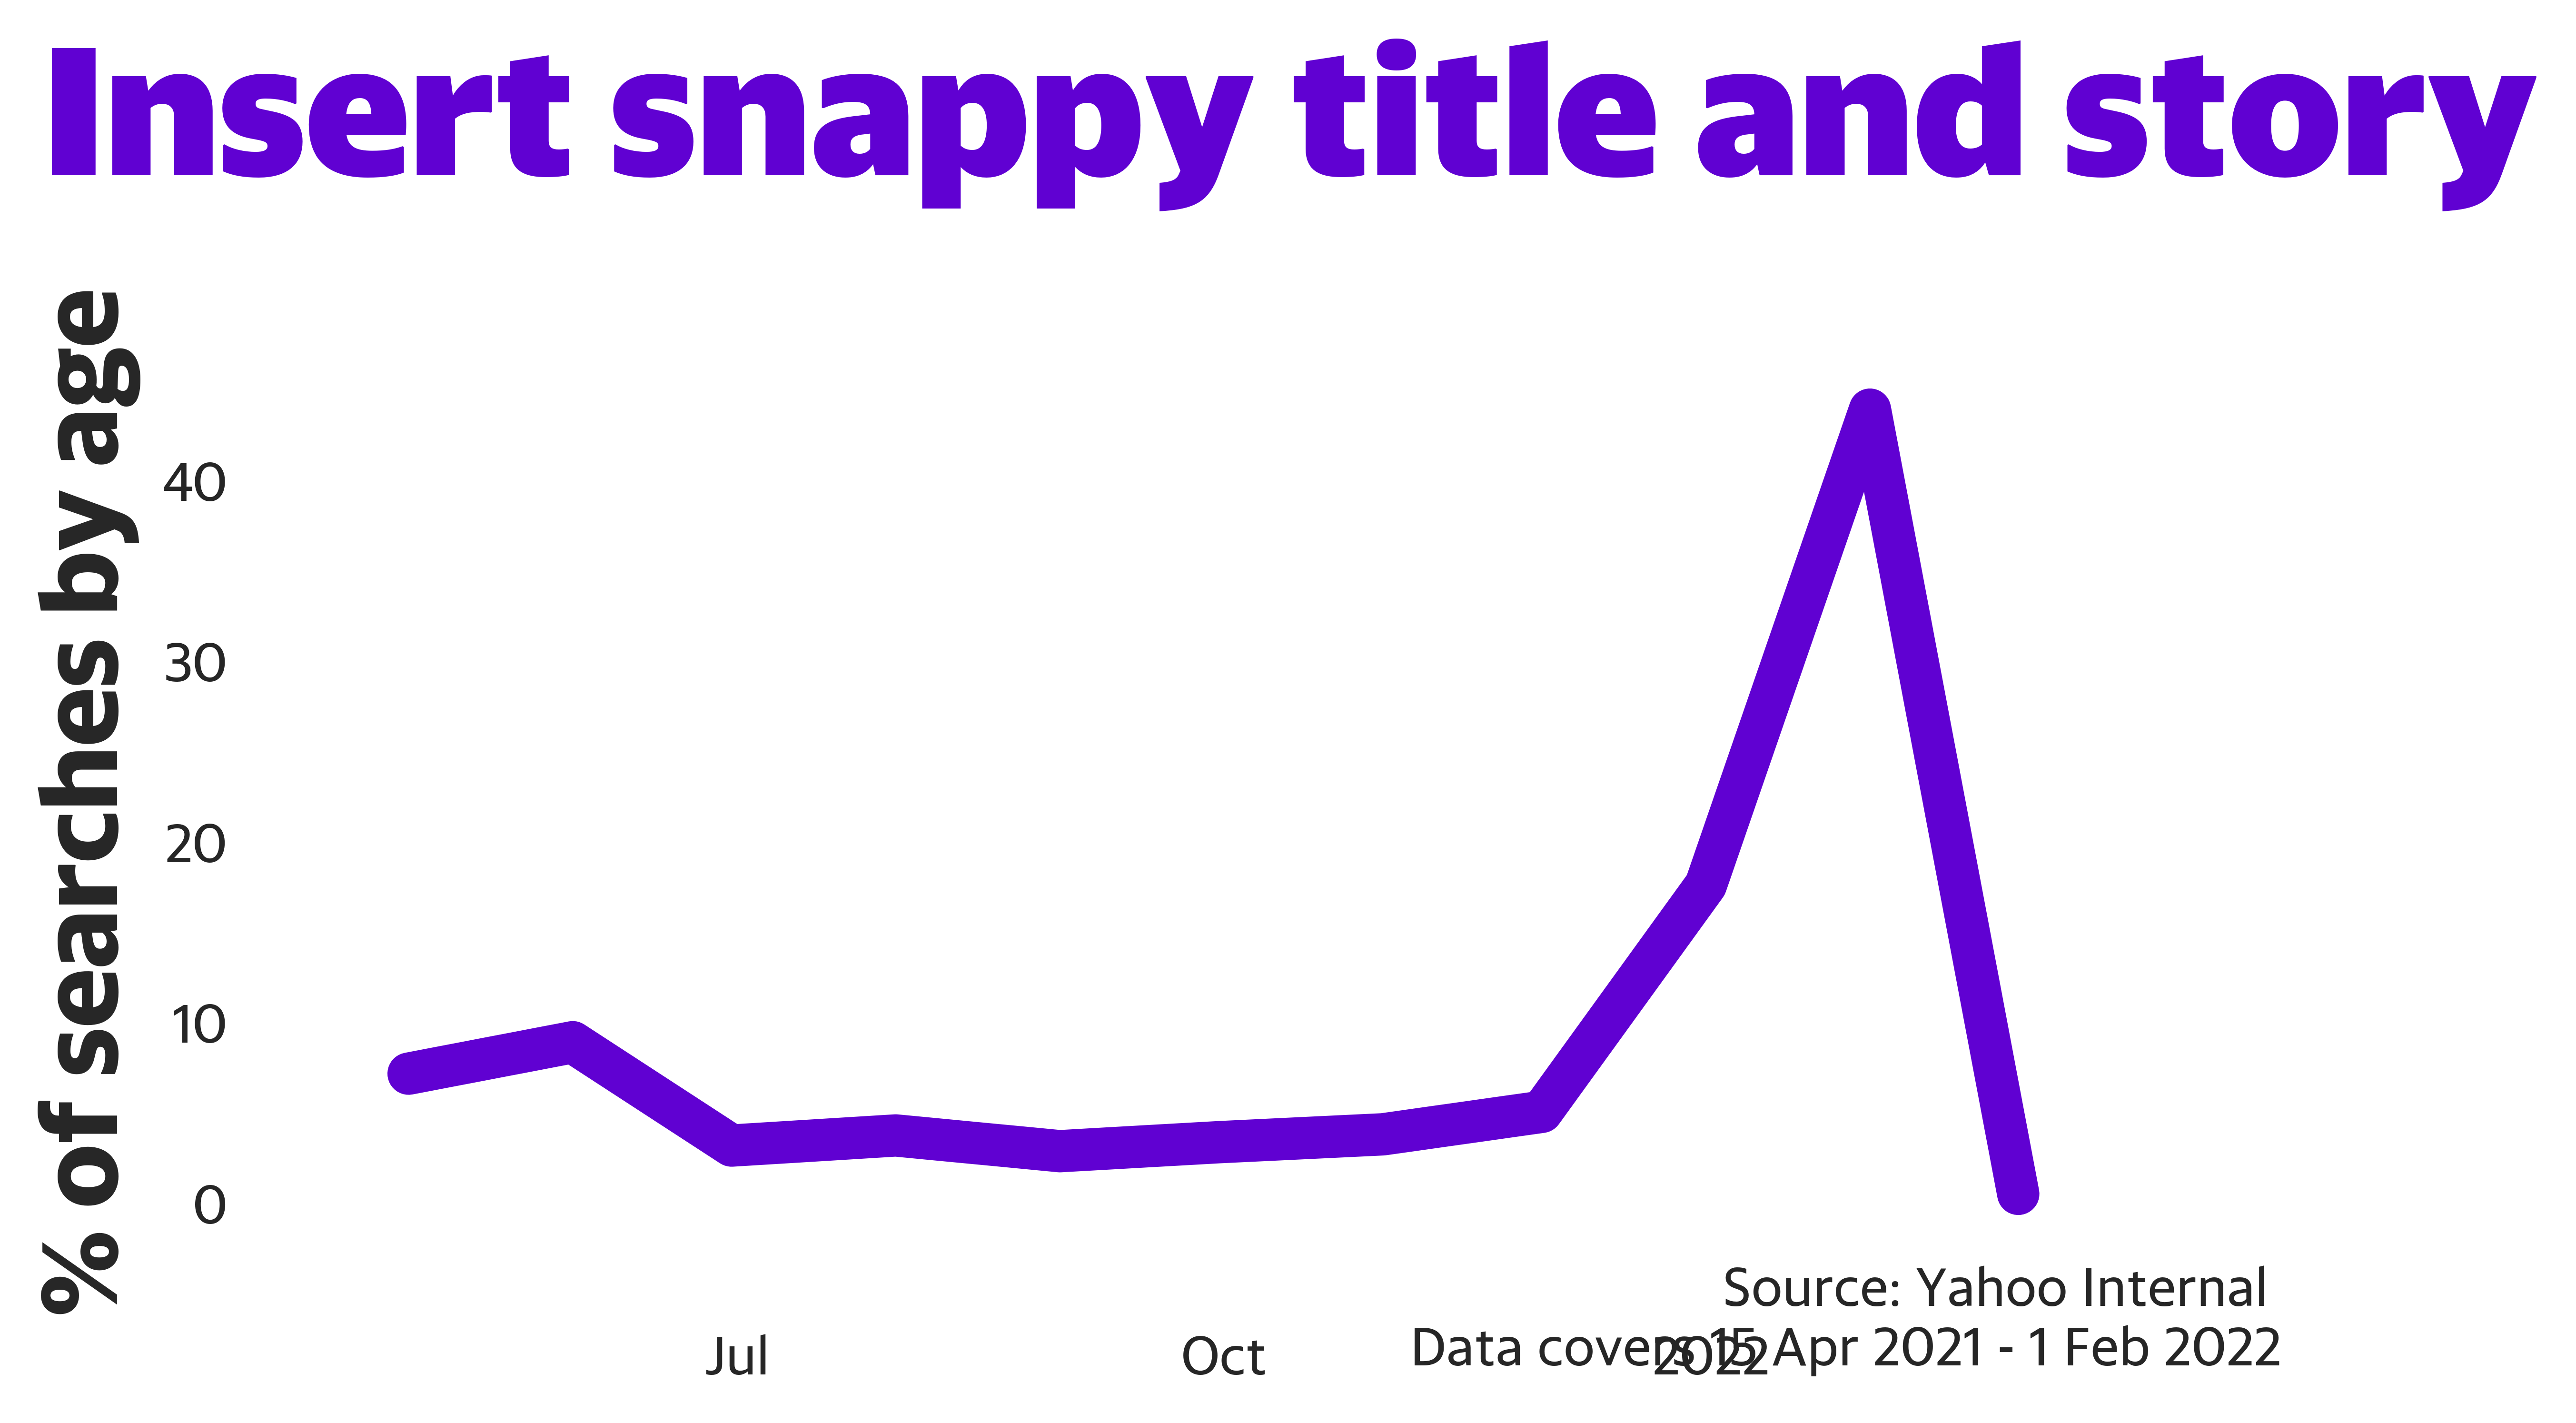

In [199]:
# Theme
sns.set_theme(font='Yahoo Sans', context='talk', style='white', palette=yahoo_palette, rc={'figure.dpi':600})

# Shape Data // TODO VARIABLES FOR TIME AND GENDER
time_plot = (df
                .groupby(pd.Grouper(freq='M', key='date'))
                .agg(total=('query', 'size'))
                .reset_index()
                .assign(perc=lambda df: df['total'].div(df['total'].sum()).mul(100)))

fig, ax = plt.subplots(figsize=(6,3), dpi=800)
sns.lineplot(x = 'date', y = 'perc', data=time_plot, lw=8, legend=False, ax=ax)


# Axis Labels & Reference Band
locator = mdates.AutoDateLocator(minticks=2, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)

s = 'Insert snappy title and story'
s2 = 'Insert a snappy subheadline to go here using the fields across. wrap words in brackets to <bold>' 
fig.text(0.00, 0.92, s, fontsize=34, va='bottom',  color='#6001D2', fontfamily='Yahoo Sans', fontweight='heavy')  

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set(ylabel="", xlabel="")
ax.set_xlabel('')
ax.set_ylabel('% of searches by age', fontsize=20, fontweight='bold')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelsize=10, pad=10)

pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0 - 0.1,  pos1.width, pos1.height]
ax.set_position(pos2)
    
for direction in ['bottom', 'left']:
    ax.spines[direction].set_lw(0.2)
    ax.spines[direction].set_color('grey')
    ax.spines[direction].set_alpha(0.5)
    
    # ax.text(0.00, 0.89, s2, fontsize=6, va='bottom')

sns.despine(bottom=True, left=True)

# Source
fig.supxlabel(f'Source: Yahoo Internal \nData covers {research_start} - {research_end}', fontsize=10, x=0.98, y=-0.1, ha='right')


plt.savefig('images/weekly_seasonality.png', dpi=1000, transparent=True)



In [402]:
weights = ['ultralight', 'light', 'normal', 'regular', 'book', 'medium', 
           'roman', 'semibold', 'demibold', 'demi', 'bold', 'heavy', 
           'extra bold', 'black']
           
for weight in weights:
    fprops = font_manager.FontProperties(family='Yahoo Sans', 
                                                    weight=weight)
    print(weight, font_manager.findfont(fprops))

ultralight /Library/Fonts/Yahoo Sans-ExtraLight.otf
light /Library/Fonts/Yahoo Sans-ExtraLight.otf
normal /Library/Fonts/Yahoo Sans-Regular.otf
regular /Library/Fonts/Yahoo Sans-Regular.otf
book /Library/Fonts/Yahoo Sans-Regular.otf
medium /Library/Fonts/Yahoo Sans-Medium.otf
roman /Library/Fonts/Yahoo Sans-Medium.otf
semibold /Library/Fonts/Yahoo Sans-Semibold.otf
demibold /Library/Fonts/Yahoo Sans-Semibold.otf
demi /Library/Fonts/Yahoo Sans-Semibold.otf
bold /Library/Fonts/Yahoo Sans-Bold.otf
heavy /Library/Fonts/Yahoo Sans-ExtraBold.otf
extra bold /Library/Fonts/Yahoo Sans-ExtraBold.otf
black /Library/Fonts/Yahoo Sans-Black.otf


In [458]:
holidays = pd.read_csv('raw data/custom_holidays.csv')
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%d/%m/%Y')

custom_date = datetime(2022, 1, 19)
custom_name = "Restrictions Ease"

holidays.append({'holiday':custom_name, 'ds':custom_date, 'lower_window':0, 'upper_window':0}, ignore_index=True)

holidays

,holiday,ds,lower_window,upper_window
0,New Years Eve,2021-12-31,0,0
1,Black Friday 2021,2021-11-26,0,0
2,Cyber Monday 2021,2021-11-29,0,0


In [473]:
df = pd.read_csv('raw data/sustainable time.csv')

df = df.loc[:, ['search', 'date', 'age', 'gender']].dropna(subset=['search']).fillna('Unknown')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['search'] = (df['search'].str.replace('_', ' ').str.replace('(\S{14,})|[^\w\s]|  +', '').str.strip().str.lower().apply(lambda row: ' '.join([word for word in row.split() if word not in (stopwords)])))

df.to_csv('raw data/demo data.csv', index=False)